# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [4]:
# Load in the general demographics data.
demographics = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
# Load in the feature summary file.
feature_summary = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')


In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print (demographics.shape)
demographics.head()


(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`.

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
feature_summary.head(85)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [7]:
demographics_nan = demographics.copy()

# the problem was that X and XX were considered variables when applying ast.literal_eval
def parse_missing_or_unknown(value):
    try:
        # Replace 'X' and 'XX' with string literals before parsing
        value = value.replace('X', '"X"').replace('XX', '"XX"')
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return []  # Return an empty list if parsing fails

feature_summary['missing_or_unknown'] = feature_summary['missing_or_unknown'].apply(parse_missing_or_unknown)

for feature_idx, feature_name in enumerate(demographics.columns):
    # Get missing values for the current feature from data2
    missing_values = feature_summary.iloc[feature_idx, 3]

    if not missing_values:  # Skip if no missing values are defined
        continue

    # Replace missing values in the current column with NaN
    demographics_nan[feature_name] = demographics[feature_name].replace(missing_values, np.nan, inplace=False)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
# debugging
demographics_nan.loc[demographics_nan['AGER_TYP'] == -1].head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB


In [9]:
demographics.loc[demographics['AGER_TYP'] == -1].head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
6,-1,2,2,5.0,1,5,1,5,4,3,4,0,12.0,0,2,2.0,1.0,1.0,1.0,2.0,1.0,1,10,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1,0.0,0.0,1,4,0.0,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0


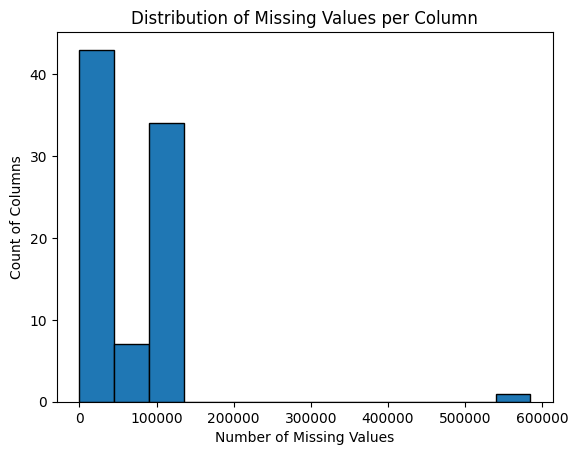

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing_counts = demographics.isnull().sum()
missing_proportion = missing_counts / len(demographics) * 100


plt.hist(missing_counts, bins='auto', edgecolor='black')
plt.xlabel('Number of Missing Values')
plt.ylabel('Count of Columns')
plt.title('Distribution of Missing Values per Column')
plt.show()



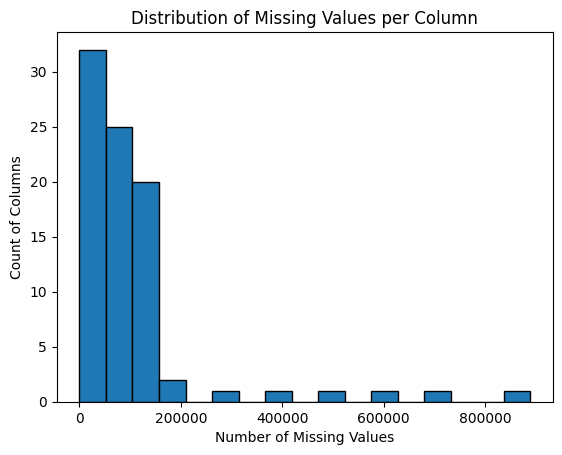

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing_counts = demographics_nan.isnull().sum()
missing_proportion = missing_counts / len(demographics_nan) * 100



plt.hist(missing_counts, bins='auto', edgecolor='black')
plt.xlabel('Number of Missing Values')
plt.ylabel('Count of Columns')
plt.title('Distribution of Missing Values per Column')
plt.show()



In [12]:
missing_proportion.sort_values().head(85)

,0
ANREDE_KZ,0.000000
GREEN_AVANTGARDE,0.000000
SEMIO_TRADV,0.000000
SEMIO_PFLICHT,0.000000
SEMIO_KAEM,0.000000
SEMIO_DOM,0.000000
SEMIO_KRIT,0.000000
SEMIO_RAT,0.000000
SEMIO_KULT,0.000000
SEMIO_ERL,0.000000


In [13]:
demographics['KK_KUNDENTYP'].head(10)

,KK_KUNDENTYP
0,NaN
1,NaN
2,NaN
3,NaN
4,1.0
5,3.0
6,NaN
7,NaN
8,NaN
9,6.0


In [14]:
demographics_nan['KK_KUNDENTYP'].head(10)

,KK_KUNDENTYP
0,NaN
1,NaN
2,NaN
3,NaN
4,1.0
5,3.0
6,NaN
7,NaN
8,NaN
9,6.0


In [15]:
missing_counts_sorted = missing_counts.sort_values(ascending=False)
missing_counts_sorted

,0
TITEL_KZ,889061
AGER_TYP,685843
KK_KUNDENTYP,584612
KBA05_BAUMAX,476524
GEBURTSJAHR,392318
ALTER_HH,310267
KKK,158064
REGIOTYP,158064
W_KEIT_KIND_HH,147988
KBA05_ANTG1,133324


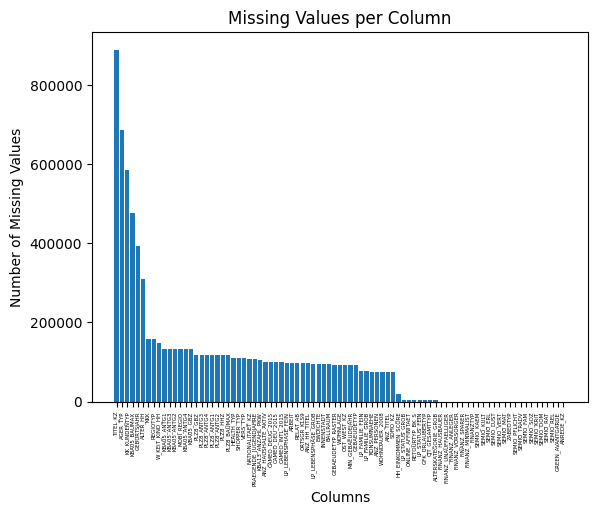

In [16]:
# Investigate patterns in the amount of missing data in each column.



plt.bar(missing_counts_sorted.index, missing_counts_sorted.values)
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values per Column')
plt.xticks(rotation=90, fontsize=4)
plt.show()

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_columns = missing_proportion[missing_proportion > 30].index
outlier_columns


Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

In [18]:
demographics_nan_dropped = demographics_nan.drop(columns=outlier_columns)
demographics_nan_dropped.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Six columns: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'] were considered outlier columns and were thus removed from the dataset. They are visible from the barplot.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

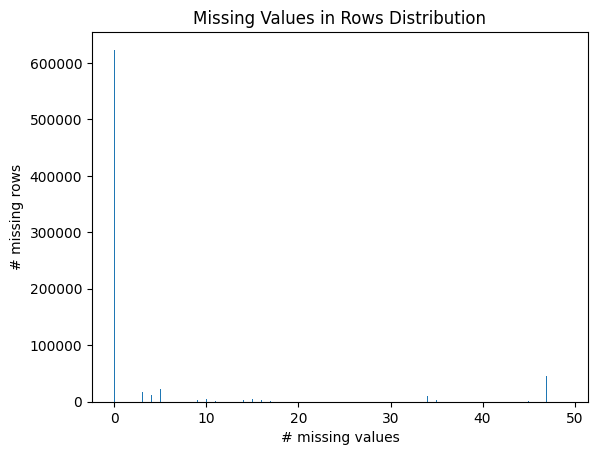

In [19]:
# How much data is missing in each row of the dataset?

# Calculate the number of missing values in each row
demographics_nan_dropped['missing_count'] = demographics_nan_dropped.isnull().sum(axis=1)

plt.hist(demographics_nan_dropped['missing_count'], bins='auto')
plt.xlabel('# missing values')
plt.ylabel('# missing rows')
plt.title('Missing Values in Rows Distribution')
plt.show()


In [20]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 7  # Example threshold; adjust based on your data
subset_above_threshold = demographics_nan_dropped[demographics_nan_dropped['missing_count'] > threshold]
subset_below_threshold = demographics_nan_dropped[demographics_nan_dropped['missing_count'] <= threshold]

demographics_nan_dropped = demographics_nan_dropped.drop(columns=['missing_count'])
subset_above_threshold = subset_above_threshold.drop(columns=['missing_count'])
subset_below_threshold = subset_below_threshold.drop(columns=['missing_count'])

demographics_nan_dropped = subset_below_threshold

# Print the sizes of the subsets
print(f"Rows above threshold: {len(subset_above_threshold)}")
print(f"Rows below threshold: {len(subset_below_threshold)}")


Rows above threshold: 144112
Rows below threshold: 747109


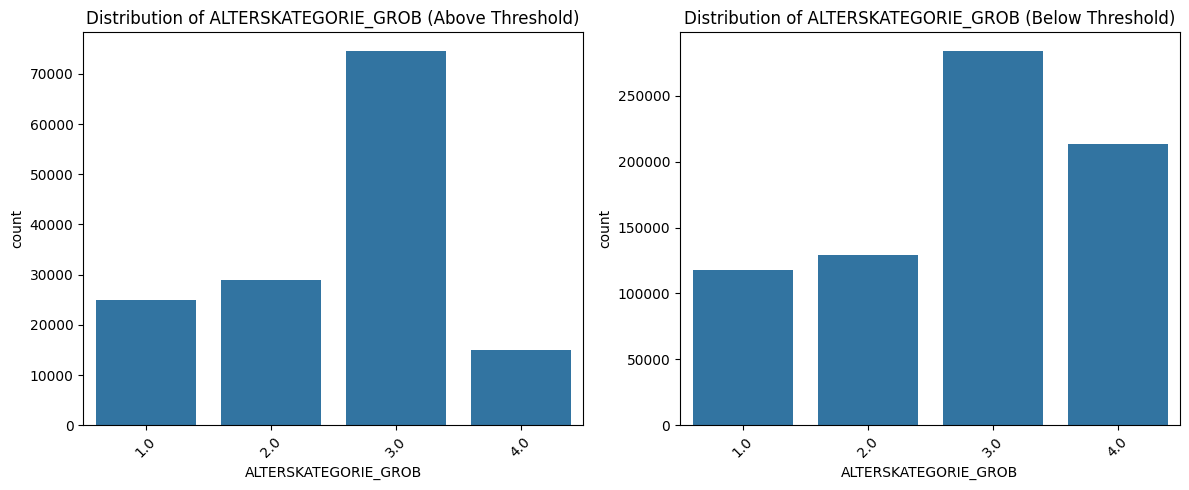

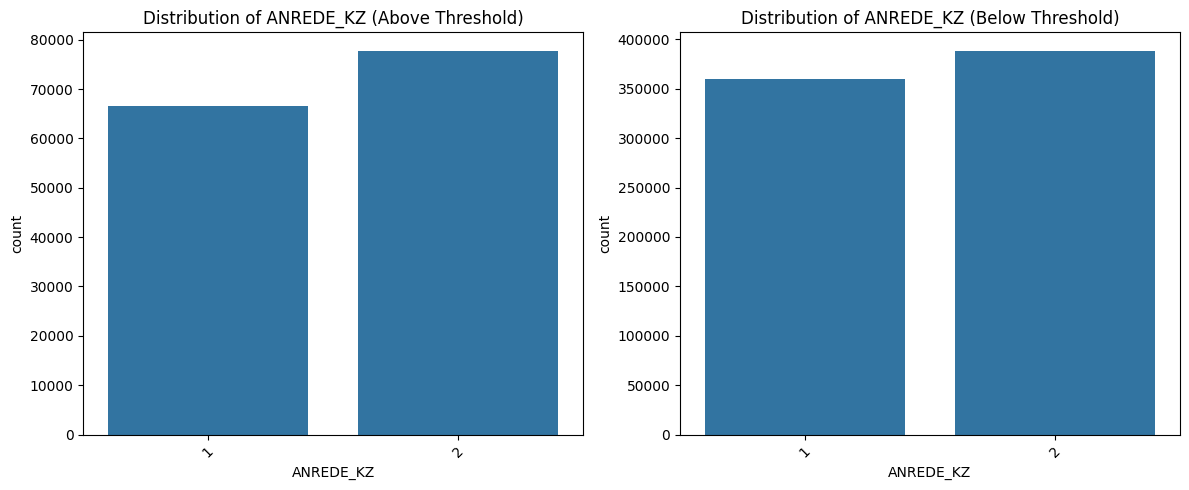

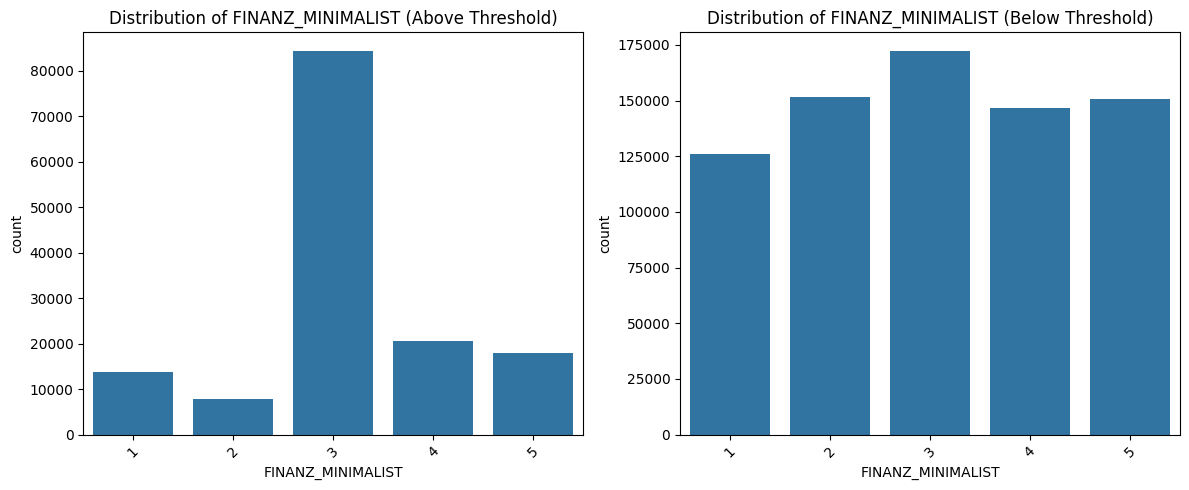

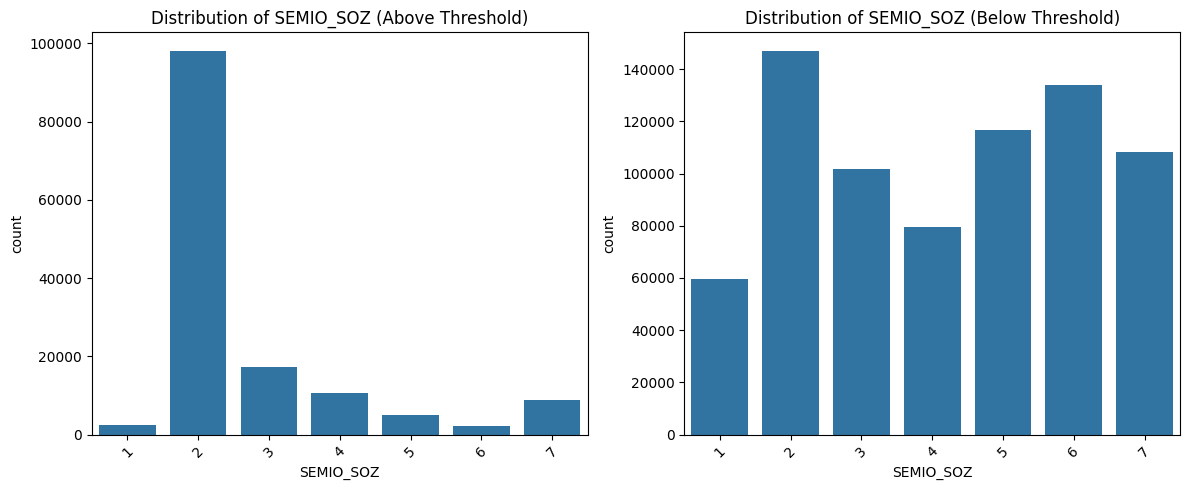

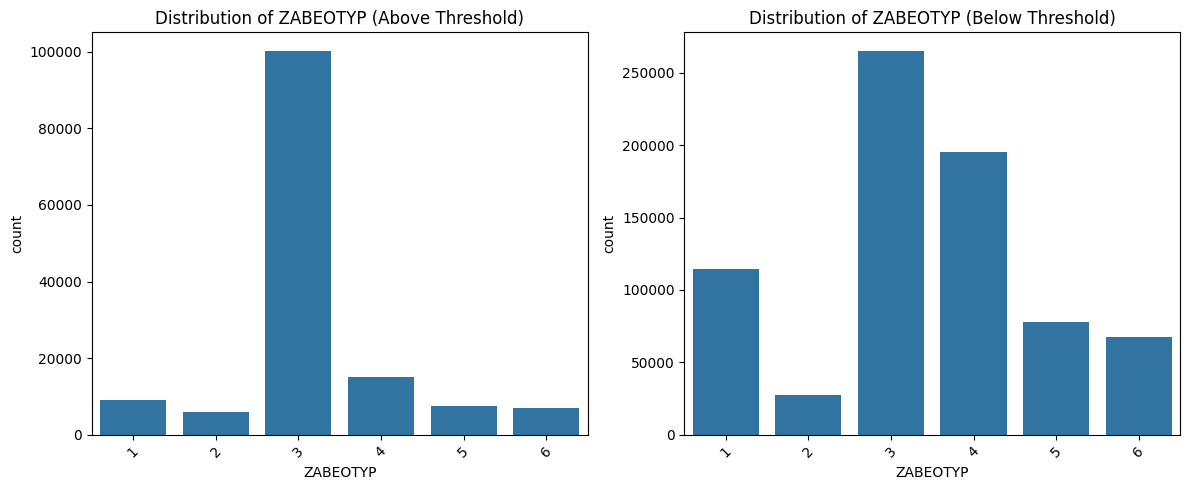

In [21]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_distributions(col, subset1, subset2, title1, title2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot for subset1
    sns.countplot(data=subset1, x=col, ax=axes[0])
    axes[0].set_title(title1)
    axes[0].tick_params(axis='x', rotation=45)

    # Plot for subset2
    sns.countplot(data=subset2, x=col, ax=axes[1])
    axes[1].set_title(title2)
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Select columns with little or no missing data
columns_to_compare = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'SEMIO_SOZ', 'ZABEOTYP']

# Compare distributions for each column
for col in columns_to_compare:
    compare_distributions(
        col,
        subset_above_threshold,
        subset_below_threshold,
        f"Distribution of {col} (Above Threshold)",
        f"Distribution of {col} (Below Threshold)"
    )


#### Discussion 1.1.3: Assess Missing Data in Each Row

The columns: ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'SEMIO_SOZ', 'ZABEOTYP'] were selected to compare the two subsets of missing values. For four of the columns, data seemed to be different between the two subsets, so they should not be dropped.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
filtered_feature_summary = feature_summary[feature_summary['attribute'].isin(demographics_nan_dropped.columns)]
filtered_feature_summary.shape

(79, 4)

In [23]:
# How many features are there of each data type?
feat_type_counts = filtered_feature_summary['type'].value_counts()
feat_type_counts


,count
type,
ordinal,49
categorical,18
mixed,6
numeric,6


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [24]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Step 1: Identify categorical features
categorical_features = filtered_feature_summary[filtered_feature_summary['type'].isin(['categorical'])]['attribute']

# Step 2: Handle binary categorical features
binary_features = []
for feature in categorical_features:
    if demographics_nan_dropped[feature].nunique() == 2:
        binary_features.append(feature)

# Step 3: Handle multi-level categorical features
multi_level_features = []
for feature in categorical_features:
    if demographics_nan_dropped[feature].nunique() > 2:
        multi_level_features.append(feature)







In [25]:
# Re-encode categorical variable(s) to be kept in the analysis.

for feature in binary_features:
    if not np.issubdtype(demographics_nan[feature].dtype, np.number):
        demographics_nan_dropped[feature] = demographics_nan_dropped[feature].astype('category').cat.codes


# One-Hot Encode multi-level categorical features
demographics_nan_dropped = pd.get_dummies(demographics_nan_dropped, columns=multi_level_features, drop_first=True)

# Step 4: Document your choices
print("Binary features re-encoded:", binary_features)
print("Multi-level features one-hot encoded:", multi_level_features)

Binary features re-encoded: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi-level features one-hot encoded: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [26]:
demographics_nan_dropped.shape

(747109, 181)

#### Discussion 1.2.1: Re-Encode Categorical Features

The categorical variables were examined and divided into two categories: binary variables and multi-category variables. For the multi-category variables, one-hot encoding was applied instead of discarding them, increasing the total number of columns from **79** to **183**.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [27]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Create a mapping for DECADE and MOVEMENT based on PRAEGENDE_JUGENDJAHRE
decade_mapping = {
    1: 40,  # 40s
    2: 40,  # 40s
    3: 50,  # 50s
    4: 50,  # 50s
    5: 60,  # 60s
    6: 60,  # 60s
    7: 60,  # 60s
    8: 70,  # 70s
    9: 70,  # 70s
    10: 80, # 80s
    11: 80, # 80s
    12: 80, # 80s
    13: 80, # 80s
    14: 90, # 90s
    15: 90  # 90s
}

movement_mapping = {
    1: 0,  # Mainstream
    2: 1,  # Avantgarde
    3: 0,  # Mainstream
    4: 1,  # Avantgarde
    5: 0,  # Mainstream
    6: 1,  # Avantgarde
    7: 1,  # Avantgarde
    8: 0,  # Mainstream
    9: 1,  # Avantgarde
    10: 0, # Mainstream
    11: 1, # Avantgarde
    12: 0, # Mainstream
    13: 1, # Avantgarde
    14: 0, # Mainstream
    15: 1  # Avantgarde
}

# Create new columns for DECADE and MOVEMENT
demographics_nan_dropped['DECADE'] = demographics_nan_dropped['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)
demographics_nan_dropped['MOVEMENT'] = demographics_nan_dropped['PRAEGENDE_JUGENDJAHRE'].map(movement_mapping)

# Drop the original PRAEGENDE_JUGENDJAHRE column
demographics_nan_dropped = demographics_nan_dropped.drop(columns=['PRAEGENDE_JUGENDJAHRE'])

In [28]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Create new columns for WEALTH and LIFE_STAGE
demographics_nan_dropped['WEALTH'] = demographics_nan_dropped['CAMEO_INTL_2015'].str[0].astype(float)
demographics_nan_dropped['LIFE_STAGE'] = demographics_nan_dropped['CAMEO_INTL_2015'].str[1].astype(float)

# Drop the original CAMEO_INTL_2015 column
demographics_nan_dropped = demographics_nan_dropped.drop(columns=['CAMEO_INTL_2015'])


#### Discussion 1.2.2: Engineer Mixed-Type Features

In the analysis of mixed variables, some features contained multiple pieces of information within a single column, with each row representing two distinct variables.  

We specifically focused on the mixed variables: **"Dominating movement of a person's youth (avant-garde vs. mainstream; east vs. west)"** and **"German CAMEO."** For the first variable, since the data structure was relatively simple and there was no clear pattern between the encoding and the mixed values, we directly mapped the two new variables, **PRAEGENDE_JUGENDJAHRE_MOVEMENT** and **PRAEGENDE_JUGENDJAHRE_DECADE**.  

For the second mixed column, **"CAMEO_INTL_2015,"** the encoding followed a structured format where the **tens place** represented the wealth level and the **ones place** indicated the life stage. These were easily separated by dividing by 10 to extract the wealth level and taking the remainder to obtain the life stage. Before processing, any **"XX"** values were replaced with **NaN**.  

After splitting these mixed variables into separate features, the original mixed columns were dropped from the dataset.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [29]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [30]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [31]:
# the problem was that X and XX were considered variables when applying ast.literal_eval
def parse_missing_or_unknown(value):
    try:
        # Replace 'X' and 'XX' with string literals before parsing
        value = value.replace('X', '"X"').replace('XX', '"XX"')
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return []  # Return an empty list if parsing fails

In [32]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    cleaned_df = df.copy()


    for feature_idx, feature_name in enumerate(df.columns):
        # Get missing values for the current feature from data2
        missing_values = feature_summary.iloc[feature_idx, 3]

        if not missing_values:  # Skip if no missing values are defined
            continue

        # Replace missing values in the current column with NaN
        cleaned_df[feature_name] = df[feature_name].replace(missing_values, np.nan, inplace=False)


    # remove selected columns and rows, ...

    # drop the columns
    missing_counts = cleaned_df.isnull().sum()
    missing_proportion = missing_counts / len(cleaned_df) * 100
    outlier_columns = missing_proportion[missing_proportion > 30].index
    cleaned_df = cleaned_df.drop(columns=outlier_columns)

    # drop the rows
    cleaned_df['missing_count'] = cleaned_df.isnull().sum(axis=1)
    threshold = 7  # Example threshold; adjust based on your data
    subset_above_threshold = cleaned_df[cleaned_df['missing_count'] > threshold]
    subset_below_threshold = cleaned_df[cleaned_df['missing_count'] <= threshold]

    cleaned_df = cleaned_df.drop(columns=['missing_count'])
    subset_above_threshold = subset_above_threshold.drop(columns=['missing_count'])
    subset_below_threshold = subset_below_threshold.drop(columns=['missing_count'])
    cleaned_df = subset_below_threshold

    # select, re-encode, and engineer column values.

    # Step 1: Identify categorical features
    filtered_feature_summary = feature_summary[feature_summary['attribute'].isin(cleaned_df.columns)]
    categorical_features = filtered_feature_summary[filtered_feature_summary['type'].isin(['categorical'])]['attribute']

    # Step 2: Handle binary categorical features
    binary_features = []
    for feature in categorical_features:
        if cleaned_df[feature].nunique() == 2:
            binary_features.append(feature)

    # Step 3: Handle multi-level categorical features
    multi_level_features = []
    for feature in categorical_features:
        if cleaned_df[feature].nunique() > 2:
            multi_level_features.append(feature)

    for feature in binary_features:
        if not np.issubdtype(cleaned_df[feature].dtype, np.number):
            cleaned_df[feature] = cleaned_df[feature].astype('category').cat.codes


    # One-Hot Encode multi-level categorical features
    cleaned_df = pd.get_dummies(cleaned_df, columns=multi_level_features, drop_first=True)

    decade_mapping = {
        1: 40,  # 40s
        2: 40,  # 40s
        3: 50,  # 50s
        4: 50,  # 50s
        5: 60,  # 60s
        6: 60,  # 60s
        7: 60,  # 60s
        8: 70,  # 70s
        9: 70,  # 70s
        10: 80, # 80s
        11: 80, # 80s
        12: 80, # 80s
        13: 80, # 80s
        14: 90, # 90s
        15: 90  # 90s
    }

    movement_mapping = {
        1: 0,  # Mainstream
        2: 1,  # Avantgarde
        3: 0,  # Mainstream
        4: 1,  # Avantgarde
        5: 0,  # Mainstream
        6: 1,  # Avantgarde
        7: 1,  # Avantgarde
        8: 0,  # Mainstream
        9: 1,  # Avantgarde
        10: 0, # Mainstream
        11: 1, # Avantgarde
        12: 0, # Mainstream
        13: 1, # Avantgarde
        14: 0, # Mainstream
        15: 1  # Avantgarde
    }

    # Create new columns for DECADE and MOVEMENT
    cleaned_df['DECADE'] = cleaned_df['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)
    cleaned_df['MOVEMENT'] = cleaned_df['PRAEGENDE_JUGENDJAHRE'].map(movement_mapping)

    # Drop the original PRAEGENDE_JUGENDJAHRE column
    cleaned_df = cleaned_df.drop(columns=['PRAEGENDE_JUGENDJAHRE'])

    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    # Create new columns for WEALTH and LIFE_STAGE
    cleaned_df['WEALTH'] = cleaned_df['CAMEO_INTL_2015'].str[0].astype(float)
    cleaned_df['LIFE_STAGE'] = cleaned_df['CAMEO_INTL_2015'].str[1].astype(float)

    # Drop the original CAMEO_INTL_2015 column
    cleaned_df = cleaned_df.drop(columns=['CAMEO_INTL_2015'])

    # Return the cleaned dataframe.
    return cleaned_df



## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [33]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imputer = SimpleImputer(strategy='median')  # Replace missing values with the median
demographics_imputed = pd.DataFrame(imputer.fit_transform(demographics_nan_dropped), columns=demographics_nan_dropped.columns)


In [34]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
demographics_scaled = pd.DataFrame(scaler.fit_transform(demographics_imputed), columns=demographics_imputed.columns)

### Discussion 2.1: Apply Feature Scaling

After median imputation, which is not sensitive to outliers, standardization is employed, because PCA requires standardization.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [35]:
# Apply PCA to the data.
pca = PCA()
demographics_pca = pca.fit_transform(demographics_scaled)


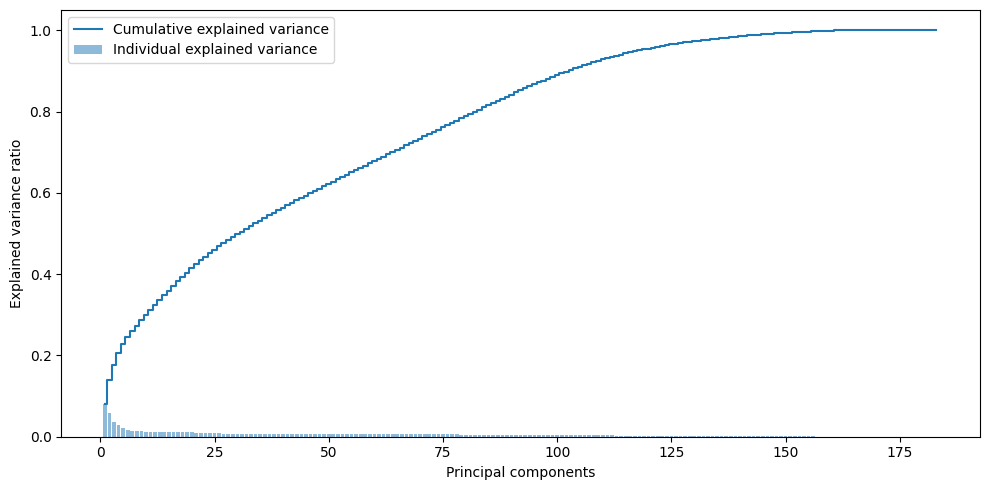

In [36]:
# Investigate the variance accounted for by each principal component.
variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance)

# Plot the variance explained by each principal component. Barplot
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(variance) + 1), variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()



In [37]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(125)
demographics_pca = pca.fit_transform(demographics_scaled)


In [38]:
demographics_scaled.shape

(747109, 183)

### Discussion 2.2: Perform Dimensionality Reduction

According to the plotted graph, the number of appropriate principal components seem to be 125, since no there is no significant variance increase. This corresponds to almost two thirds of the original features.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [39]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def print_sorted_weights(i):
  pca.components_[i]
  weights = pd.Series(pca.components_[i], index=demographics_scaled.columns)
  sorted_weights = weights.sort_values(ascending=False)
  print(sorted_weights)

print_sorted_weights(0)



MOBI_REGIO               0.209767
KBA05_ANTG1              0.194899
PLZ8_ANTG1               0.192398
FINANZ_MINIMALIST        0.188352
KBA05_GBZ                0.185682
KONSUMNAEHE              0.141836
PLZ8_GBZ                 0.141369
LP_LEBENSPHASE_FEIN      0.138910
INNENSTADT               0.133993
LP_LEBENSPHASE_GROB      0.125467
LP_STATUS_FEIN_10.0      0.115246
LP_STATUS_GROB_5.0       0.115246
LIFE_STAGE               0.112995
LP_STATUS_GROB_4.0       0.112188
LP_STATUS_FEIN_9.0       0.110972
GREEN_AVANTGARDE         0.101282
MOVEMENT                 0.101282
BALLRAUM                 0.101097
GEBAEUDETYP_RASTER       0.100488
CAMEO_DEUG_2015_2        0.091519
ANZ_PERSONEN             0.089065
ALTERSKATEGORIE_GROB     0.087788
FINANZ_VORSORGER         0.086023
FINANZTYP_2              0.080139
CAMEO_DEUG_2015_4        0.076560
LP_FAMILIE_GROB_5.0      0.075240
WOHNLAGE                 0.067790
CAMEO_DEUG_2015_3        0.067001
KBA13_ANZAHL_PKW         0.065582
SEMIO_LUST    

In [40]:
pca.components_[0].shape

(183,)

In [41]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_sorted_weights(1)

DECADE                   0.242281
FINANZ_SPARER            0.230329
SEMIO_REL                0.221140
FINANZ_UNAUFFAELLIGER    0.215114
SEMIO_TRADV              0.213177
SEMIO_PFLICHT            0.211207
FINANZ_ANLEGER           0.207287
SEMIO_KULT               0.173717
SEMIO_RAT                0.170249
ONLINE_AFFINITAET        0.162311
SEMIO_FAM                0.138633
SEMIO_MAT                0.133909
ZABEOTYP_4               0.111170
FINANZTYP_4              0.096474
ZABEOTYP_5               0.093903
LP_STATUS_FEIN_2.0       0.092740
LP_STATUS_FEIN_5.0       0.079604
FINANZTYP_3              0.075332
GFK_URLAUBERTYP_9.0      0.074380
LP_FAMILIE_GROB_4.0      0.068323
PLZ8_ANTG1               0.067474
SEMIO_SOZ                0.067470
MOBI_REGIO               0.065037
KBA05_GBZ                0.064670
ANZ_PERSONEN             0.064295
CJT_GESAMTTYP_4.0        0.057350
KBA05_ANTG1              0.056152
HEALTH_TYP               0.055589
INNENSTADT               0.054642
KONSUMNAEHE   

In [42]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_sorted_weights(2)

ANREDE_KZ                0.346714
SEMIO_KAEM               0.314213
SEMIO_DOM                0.278409
SEMIO_KRIT               0.262895
SEMIO_ERL                0.200403
FINANZ_ANLEGER           0.163340
SEMIO_RAT                0.159832
SHOPPER_TYP_2.0          0.099095
LP_STATUS_FEIN_4.0       0.084910
LP_STATUS_FEIN_2.0       0.084831
FINANZ_HAUSBAUER         0.074513
ZABEOTYP_4               0.062851
INNENSTADT               0.062770
HH_EINKOMMEN_SCORE       0.061473
FINANZ_SPARER            0.059780
LP_FAMILIE_GROB_3.0      0.058013
BALLRAUM                 0.057988
WOHNLAGE                 0.056106
DECADE                   0.054130
KKK                      0.052042
KONSUMNAEHE              0.049556
LP_FAMILIE_FEIN_4.0      0.041993
PLZ8_ANTG1               0.041407
FINANZ_UNAUFFAELLIGER    0.040359
GEBAEUDETYP_RASTER       0.038511
SHOPPER_TYP_3.0          0.037618
ZABEOTYP_3               0.035398
LP_STATUS_GROB_2.0       0.034796
REGIOTYP                 0.033226
NATIONALITAET_

### Discussion 2.3: Interpret Principal Components

First Principcal Component: \\
  The first principcal component mostly describes the number of family houses in the PLZ8 region. I've seen that it gives high positivve weights for the 1-2 family houses in the region, and high negative weights for 3-5 family houses. This seems like a reasonable negative correlation, because that region is characterized by small family houses.


Second Principal Component: \\
  The second principal component describes personality and financial topologies. It attributes positive weights to religious personality and negative weight to sensual-minded, and it's reasonable because they largely have negative correlation. It also attributes positive weight to money savers. I think religious people are also largely money savers.


Third Principal Component: \\
  The third component also describes personality. It attributes high positive weights to gender and combative and dominant personalities, while high negative weights to more relaxed personalities.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [43]:
# final dataset is demographics_pca
# Over a number of different cluster counts...
from sklearn.cluster import KMeans

scores = []

for i in range(1, 25):
  # run k-means clustering on the data and...
    cluster = KMeans(i)
    model = cluster.fit(demographics_pca)

    # compute the average within-cluster distances.
    scores.append(-model.score(demographics_pca))



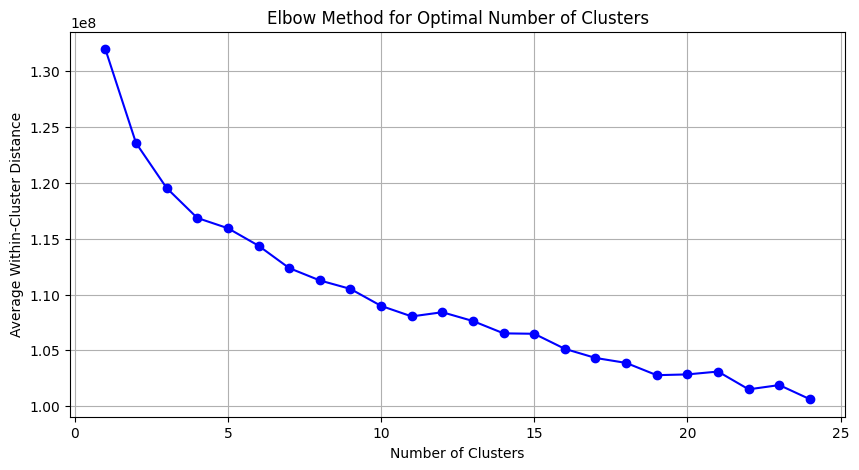

In [44]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(scores) + 1), scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Within-Cluster Distance')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()


In [45]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
cluster = KMeans(12)
model = cluster.fit(demographics_pca)
demographics_predictions = model.predict(demographics_pca)


### Discussion 3.1: Apply Clustering to General Population

The process involved applying clustering with varying number of clusters to the data, and plotting the average distances for each value of cluster numbers. Then using the elbow method, the optimal number of clusters discovered is 12.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [61]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [62]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# clean data, scale and impute
customers_cleaned = clean_data(customers)




In [63]:
missing_columns = list(set(demographics_scaled.columns)-set(customers_cleaned.columns))

for column in missing_columns:
  customers_cleaned[column] = demographics_scaled[column].median()

customers_cleaned = customers_cleaned[demographics_scaled.columns]

In [64]:
customers_imputed = pd.DataFrame(imputer.transform(customers_cleaned), columns=customers_cleaned.columns)
customers_scaled = pd.DataFrame(scaler.transform(customers_imputed), columns=customers_imputed.columns)

In [65]:
# perform PCA
customers_pca = pca.transform(customers_scaled)


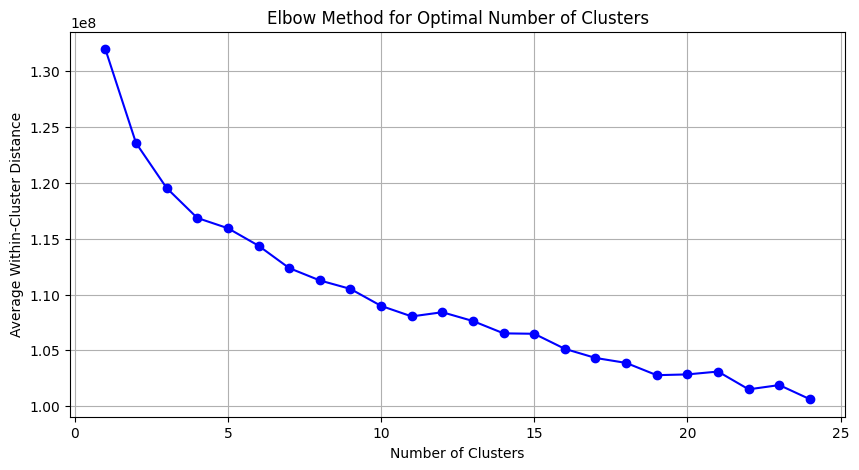

In [66]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(scores) + 1), scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Within-Cluster Distance')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()


In [67]:


customer_predictions = model.predict(customers_pca)
customer_predictions

array([1, 1, 3, ..., 1, 5, 3], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

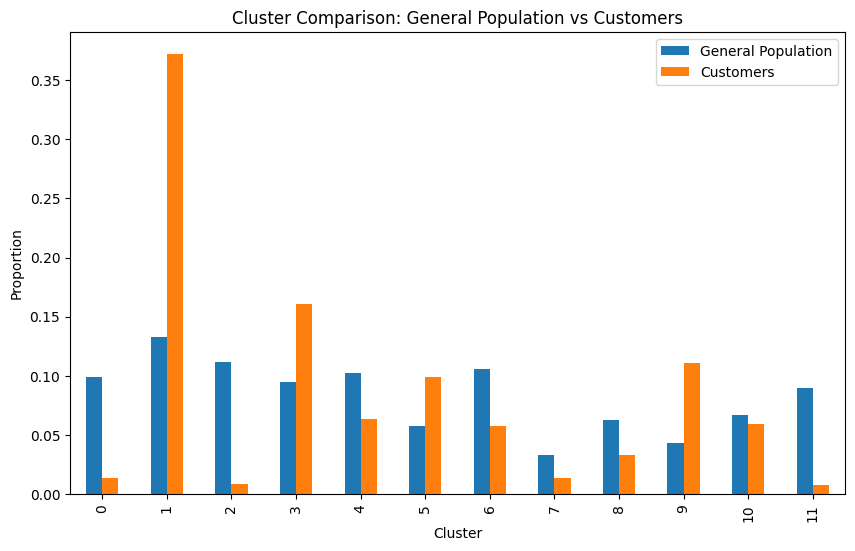

In [68]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_cluster_counts = pd.Series(demographics_predictions).value_counts(normalize=True).sort_index()
customer_cluster_counts = pd.Series(customer_predictions) .value_counts(normalize=True).sort_index()

cluster_comparison = pd. DataFrame({'General Population': general_cluster_counts, 'Customers': customer_cluster_counts})
cluster_comparison.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Cluster')
plt.ylabel('Proportion' )
plt.title('Cluster Comparison: General Population vs Customers' )
plt.show()

<ipython-input-69-79d54c063683>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_comparison.index, y=cluster_comparison['Ratio'], palette='coolwarm')


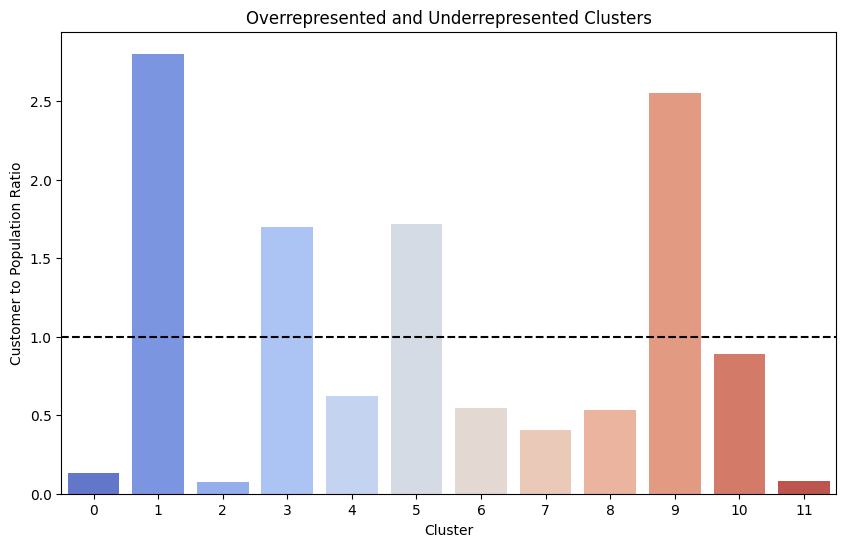

In [69]:
# Compute the ratio of customer proportions to general population proportions
cluster_comparison['Ratio'] = cluster_comparison['Customers'] / cluster_comparison['General Population']

# Plot the ratio to highlight overrepresented and underrepresented clusters
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_comparison.index, y=cluster_comparison['Ratio'], palette='coolwarm')
plt.axhline(y=1, color='black', linestyle='--')  # Reference line for equal proportions
plt.xlabel('Cluster')
plt.ylabel('Customer to Population Ratio')
plt.title('Overrepresented and Underrepresented Clusters')
plt.show()

In [70]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Sort clusters by their ratio
sorted_clusters = cluster_comparison.sort_values('Ratio', ascending=False)

# Display top overrepresented and underrepresented clusters
top_overrepresented = sorted_clusters.head(3)  # Top 3 overrepresented clusters
top_underrepresented = sorted_clusters.tail(3)  # Bottom 3 underrepresented clusters

print("Top Overrepresented Clusters:\n", top_overrepresented)
print("\nTop Underrepresented Clusters:\n", top_underrepresented)

Top Overrepresented Clusters:
    General Population  Customers     Ratio
1            0.132875   0.372164  2.800857
9            0.043469   0.110842  2.549905
5            0.057644   0.099013  1.717669

Top Underrepresented Clusters:
     General Population  Customers     Ratio
0             0.098640   0.013304  0.134873
11            0.089828   0.007212  0.080292
2             0.111770   0.008562  0.076604


In [71]:
# Get cluster centers from KMeans
cluster_centers = model.cluster_centers_

# Convert back from PCA space to scaled space
cluster_centers_scaled = pca.inverse_transform(cluster_centers)

# Convert back from scaled space to original space
original_cluster_centers = scaler.inverse_transform(cluster_centers_scaled)

# Convert to DataFrame for easier analysis
cluster_centers_df = pd.DataFrame(original_cluster_centers, columns=customers_scaled.columns)

# Display the first few rows
cluster_centers_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.745467,1.652125,2.261472,4.169953,2.138977,4.466852,4.197871,2.851894,0.214841,2.201091,18.224142,5.433150,2.391350,3.959090,4.574613,5.484873,4.853138,3.768948,3.173718,3.648798,4.880032,5.361262,4.491520,4.733593,4.272723,5.825949,5.401664,0.008438,1.484353,2.114275,0.000140,3.949366,3.225245,7.597750,2.872070,0.005211,3.827729,1993.273818,0.855020,4.747514,2.414741,1.214100,0.159803,0.022599,4.033992,4.995280,2.878960,5.562977,4.061289,2.723338,3.974348,3.793917,4.340423,699.280665,2.919742,2.339767,0.907002,0.226405,1.027671,3.486818,3.931103,2.697566,3.847184,2.430603,0.029438,0.188625,0.303450,0.177033,0.237437,0.004658,0.083151,0.293282,0.003169,0.113086,0.098486,0.050994,0.017001,0.063196,0.017877,0.020378,0.055698,0.197305,0.115527,0.109816,0.166103,0.065943,0.019125,0.036130,0.034644,0.034787,0.050623,0.057539,0.019359,0.204625,0.101286,0.065943,0.089898,0.142949,0.325270,0.121689,0.035108,0.279919,0.310253,0.000195,0.000045,0.053637,0.114352,0.040004,0.625280,0.000240,0.167989,0.040004,0.088137,0.090472,0.334301,0.242895,0.141159,0.061045,0.011923,0.472841,0.187295

In [72]:
# Identify overrepresented clusters
overrepresented_clusters = cluster_comparison[cluster_comparison['Ratio'] > 1].index
print("Overrepresented Clusters:", overrepresented_clusters)



Overrepresented Clusters: Index([1, 3, 5, 9], dtype='int32')


In [73]:
eigenvectors = pca.components_  # Shape: (3, 10)
explained_variance = pca.explained_variance_ratio_  # Shape: (3,)

In [74]:
model_labels = model.labels_

In [75]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

underrepresented_clusters = cluster_comparison[cluster_comparison['Ratio'] < 1].index
print("Underrepresented Clusters:", underrepresented_clusters)

Underrepresented Clusters: Index([0, 2, 4, 6, 7, 8, 10, 11], dtype='int32')


In [78]:
# Function to get top contributing features for a cluster with feature names
def get_top_features_for_cluster(cluster_label, eigenvectors, data_pca, k_means_labels, feature_names, n_top_features=3):
    # Get the data points in the cluster
    cluster_data = data_pca[k_means_labels == cluster_label]

    # Calculate the mean PCA scores for the cluster
    mean_pca_scores = np.mean(cluster_data, axis=0)

    # Calculate the contribution of each feature to the cluster
    feature_contributions = np.abs(np.dot(mean_pca_scores, eigenvectors))

    # Get the top contributing features (indices)
    top_features_indices = np.argsort(feature_contributions)[-n_top_features:][::-1]

    # Get the actual feature names
    top_feature_names = [feature_names[i] for i in top_features_indices]

    return top_feature_names, feature_contributions

# Get feature names from the dataset
feature_names = customers_scaled.columns  # Assuming actual_set is the original dataset

# Analyze overrepresented clusters
overrepresented_clusters = [1, 3, 5, 9]
for cluster in overrepresented_clusters:
    top_features, contributions = get_top_features_for_cluster(cluster, eigenvectors, demographics_pca, model_labels, feature_names)
    print(f"Top features for Overrepresented Cluster {cluster}: {top_features}")
    print("\n")

# Analyze underrepresented clusters
underrepresented_clusters = [0, 2, 4, 6, 7, 8, 10, 11]
for cluster in underrepresented_clusters:
    top_features, contributions = get_top_features_for_cluster(cluster, eigenvectors, demographics_pca, model_labels, feature_names)
    print(f"Top features for Underrepresented Cluster {cluster}: {top_features}")
    print("\n")

Top features for Overrepresented Cluster 1: ['LP_STATUS_GROB_5.0', 'LP_STATUS_FEIN_10.0', 'GREEN_AVANTGARDE']


Top features for Overrepresented Cluster 3: ['LP_STATUS_GROB_4.0', 'LP_STATUS_FEIN_9.0', 'FINANZ_MINIMALIST']


Top features for Overrepresented Cluster 5: ['LP_STATUS_FEIN_3.0', 'LP_STATUS_GROB_2.0', 'FINANZTYP_5']


Top features for Overrepresented Cluster 9: ['LP_STATUS_GROB_3.0', 'LP_STATUS_FEIN_6.0', 'LP_STATUS_FEIN_7.0']


Top features for Underrepresented Cluster 0: ['LP_STATUS_FEIN_5.0', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_ANLEGER']


Top features for Underrepresented Cluster 2: ['LP_STATUS_FEIN_2.0', 'FINANZ_MINIMALIST', 'SEMIO_RAT']


Top features for Underrepresented Cluster 4: ['SEMIO_KULT', 'SEMIO_ERL', 'ZABEOTYP_3']


Top features for Underrepresented Cluster 6: ['ANREDE_KZ', 'MOBI_REGIO', 'KBA05_ANTG1']


Top features for Underrepresented Cluster 7: ['CAMEO_DEU_2015_7A', 'CAMEO_DEUG_2015_7', 'LIFE_STAGE']


Top features for Underrepresented Cluster 8: ['LP_STATUS_

### Discussion 3.3: Compare Customer Data to Demographics Data

**Popular Segments:**  
The overrepresented clusters (1, 3, 5, 9) suggest the company is successful in attracting top earners, environmentally conscious individuals, financially conservative houseowners, aspiring low-income earners, and independent professionals. These groups likely respond well to the company’s current offerings, which align with their financial priorities, values, and lifestyles.

**Unpopular Segments:**  
The underrepresented clusters (0, 2, 4, 6, 7, 8, 10, 11) indicate the company struggles to engage minimalistic high-income earners, culturally-minded individuals, working-class customers, rural or localized populations, and family-oriented houseowners. To improve engagement, the company may need to adjust its product offerings, pricing, and marketing strategies to better meet the needs of these underserved groups.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.